# Various analyses with UMAP of the flipped images

In [1]:
import os
from datetime import datetime
from natsort import natsorted
import numpy as np
import matplotlib.pyplot as plt
import skimage as ski
import torch

from torchvision.transforms import v2 as transforms
from torchvision.io import read_image
from PIL import Image as PILImage
from pathlib import Path
from torchvision.utils import save_image
import torchvision.transforms.functional as TF

from torchvision import models
# from pl_bolts.models.autoencoders import AE
# from pl_bolts.models.self_supervised import SimCLR

import scanpy as sc
from matplotlib.pyplot import rc_context
from pathlib import Path
import pandas as pd
import matplotlib.image as mpimg
from colorir import *

palette = Palette.load('cam_colours')
torch.manual_seed(1)

/hps/software/users/birney/esther/micromamba/envs/indigene-img/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/hps/software/users/birney/esther/micromamba/envs/indigene-img/lib/python3.9/site-packages/torchvision/image.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKSs'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:
# Output path of generated images
today = datetime.now().strftime('%Y-%m-%d')

# Define the directory path
workdir = f"/nfs/research/birney/users/esther/medaka-img/scripts/figures/{today}/"

# Create the directory
os.makedirs(workdir, exist_ok=True)

print(workdir)

/nfs/research/birney/users/esther/medaka-img/scripts/figures/2024-05-26/


In [2]:
# Function to get all the points in a specific xy-range of a UMAP (inclusive)
# x, y must be tuples that specify the lower and upper bounds
# umap_data is the sc.tl.umap object
def get_points(x, y, umap_data):
    points = []
    samples = []
    idx = []
    
    for i in range(0, len(umap_data.obsm['X_umap'])):
        if ((x[0] <= umap_data.obsm['X_umap'][i][0] <= x[1]) & (y[0] <= umap_data.obsm['X_umap'][i][1] <= y[1])):
            points.append(umap_data.obsm['X_umap'][i])
            samples.append(umap_data.obs_names[i])
            idx.append(i)
            
    return samples, np.array(points), idx

### Visually check a random sample of images from each of the two clusters in the final UMAP
The two clusters seem to be somewhat random; with a different random seed (ie. np.random.RandomState(seed=0)) the clusters are not as distinct

In [3]:
# Load the feature matrix that was saved from scripts/get-feature-matrix.py
# feature_list = torch.load('../features/cifar10-resnet18_flipped_feature_matrix.pt')
feature_list = torch.load('../features/pythae_ResNet_AE_CIFAR_flipped_resized_input.pt')
feature_matrix = np.array(([np.array(i) for [i] in feature_list]))

# Create the AnnData object to calculate UMAP (ScanPy)
obs_names = [file.rsplit(".", 1)[0] for file in natsorted(os.listdir(path = '../flipped_transformed_images2/image/'))]

feature_matrix_anndata = sc.AnnData(X = feature_matrix)
feature_matrix_anndata.obs_names = obs_names

2024-06-11 13:39:01.274048: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-11 13:39:01.317218: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-11 13:39:03.287725: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


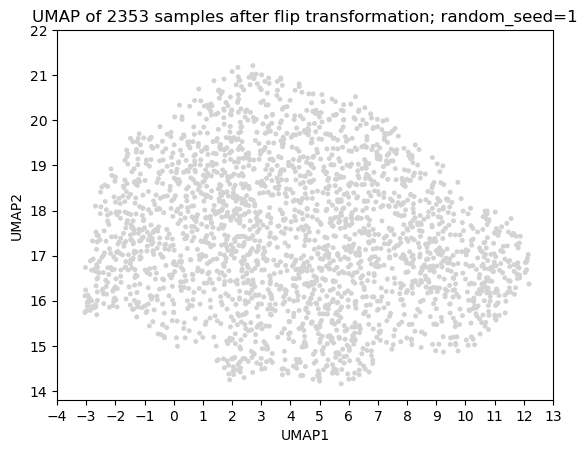

In [4]:
# Calculate UMAP with random seed = 1
seed = np.random.RandomState(seed=1)

neighbors_anndata = sc.pp.neighbors(feature_matrix_anndata,
                                     use_rep='X',
                                     n_neighbors = 49,
                                     random_state = seed,
                                     copy = True)
umap_anndata = sc.tl.umap(neighbors_anndata,
                          random_state = seed,
                          copy = True)

ax = sc.pl.umap(umap_anndata,
               show = False)
ax.set_xticks(list(range(int(np.floor(min(umap_anndata.obsm['X_umap'][:, 0]))), 
                         int(np.ceil(max(umap_anndata.obsm['X_umap'][:, 0]))) + 1, 1)))
ax.set_yticks(list(range(int(np.floor(min(umap_anndata.obsm['X_umap'][:, 1]))), 
                         int(np.ceil(max(umap_anndata.obsm['X_umap'][:, 1]))) + 1, 1)))
ax.set_title("UMAP of 2353 samples after flip transformation; random_seed=1")

# plt.savefig(workdir + 'umap_unflipped_seed1_noclusters.png')
# plt.savefig(workdir + 'umap_unflipped_seed1_noclusters.svg')

plt.show()

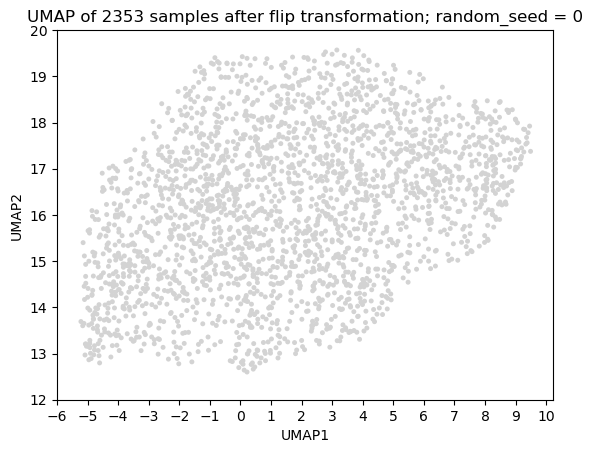

In [6]:
# Calculate UMAP
seed = np.random.RandomState(seed=0)

neighbors_anndata = sc.pp.neighbors(feature_matrix_anndata,
                                     use_rep='X',
                                     n_neighbors = 49,
                                     random_state = seed,
                                     copy = True)
umap_anndata = sc.tl.umap(neighbors_anndata,
                          random_state = seed,
                          copy = True)

ax = sc.pl.umap(umap_anndata,
               show = False)
ax.set_xticks(list(range(int(np.floor(min(umap_anndata.obsm['X_umap'][:, 0]))), 
                         int(np.ceil(max(umap_anndata.obsm['X_umap'][:, 0]))) + 1, 1)))
ax.set_yticks(list(range(int(np.floor(min(umap_anndata.obsm['X_umap'][:, 1]))), 
                         int(np.ceil(max(umap_anndata.obsm['X_umap'][:, 1]))) + 1, 1)))
ax.set_title("UMAP of 2353 samples after flip transformation; random_seed = 0")

# plt.savefig(workdir + 'umap_unflipped_seed0_twoclusters.png')
# plt.savefig(workdir + 'umap_unflipped_seed0_twoclusters.svg')

plt.show()

In [7]:
sampledata = pd.DataFrame(obs_names, columns = ['img_name'])
sampledata

,img_name
0,PLATE 1 F2 VC_Female 95-1 F14 x Male 72-1 F14_A01
1,PLATE 1 F2 VC_Female 95-1 F14 x Male 72-1 F14_A02
2,PLATE 1 F2 VC_Female 95-1 F14 x Male 72-1 F14_A03
3,PLATE 1 F2 VC_Female 95-1 F14 x Male 72-1 F14_A04
4,PLATE 1 F2 VC_Female 95-1 F14 x Male 72-1 F14_A05
...,...
2348,PLATE 25 F2 VC_ Male 11-2 F15 x Female 72-1 F1...
2349,PLATE 25 F2 VC_ Male 11-2 F15 x Female 72-1 F1...
2350,PLATE 25 F2 VC_ Male 11-2 F15 x Female 72-1 F1...
2351,PLATE 25 F2 VC_ Male 11-2 F15 x Female 72-1 F1...


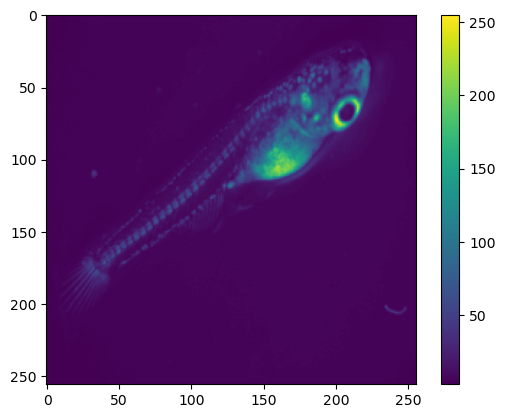

In [64]:
img = mpimg.imread('../flipped_transformed_images/image/' + 'PLATE 7 F2 VC_ Female 95-1 F14 x Male 72-1 F14_Tank bottom_A3' + '.tif')
plt.imshow(img[:,:,0])
plt.colorbar()

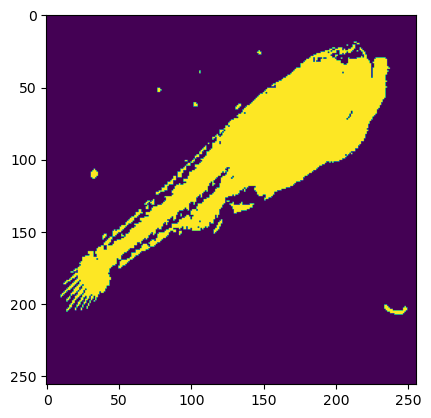

In [73]:
seg = img[:,:,0] > 10
plt.imshow(seg)

In [72]:
import skimage
#binary operations to get the biggest object
#remove small objects
#skimage
skimage.measure.regionprops_table(seg*1)

{'label': array([1]),
 'bbox-0': array([19]),
 'bbox-1': array([10]),
 'bbox-2': array([208]),
 'bbox-3': array([250])}

In [8]:
np.random.seed(2)

lower_left_samples, lower_left_points, lower_left_idx = get_points(x = (-2, 10), 
                                                                   y = (-4, 6), 
                                                                   umap_data = umap_anndata)

# Take a random subset of points in the lower left range
rand_idx = np.random.randint(low=0, high=len(lower_left_samples), size=16)

lower_left_samples_sub = [lower_left_samples[i] for i in rand_idx]
lower_left_points_sub = [lower_left_points[i] for i in rand_idx]
lower_left_idx_sub = [lower_left_idx[i] for i in rand_idx]

# Plot the UMAP
lower_left_df = pd.DataFrame({'img_name': lower_left_samples_sub, 
                              'lower_left_subset': ['lower_left']*16})
# display(lower_left_df)
# print(lower_left_df)
# print(sampledata)
sampledata2 = sampledata.merge(lower_left_df,
                              on = 'img_name',
                              how = 'left')
# display(sampledata2[sampledata2['img_name'] == 'PLATE 9 F2 VC_ Male 14-2 F14 x Female 60-1 F14_A3'])

umap_anndata.obs['lower_left_subset'] = pd.Categorical(sampledata2['lower_left_subset'])

# print(umap_anndata.obs[umap_anndata.obs[0] == 'PLATE 9 F2 VC_ Male 14-2 F14 x Female 60-1 F14_A3'])
# print(umap_anndata.obs)
# umap_anndata.obs['lower_left_subset'] = pd.Categorical(sampledata2['lower_left_subset'])
# print(umap_anndata.obs)
# print(umap_anndata.obs[lower_left_subset == 'lower_left'])

# Plot the fish images
fig, axs = plt.subplots(4, 4, figsize=(15, 15))
# plt.suptitle('Fish images on the bottom left cluster')
for i, ax in enumerate(axs.flatten()):
    if i < len(lower_left_points_sub):
        img = mpimg.imread('../flipped_transformed_images/image/' + lower_left_samples_sub[i] + '.tif')
        ax.imshow(img)
        ax.axis('off')
        ax.set_title(os.path.basename(lower_left_samples_sub[i]), fontsize = '7')
plt.tight_layout()
# plt.savefig(workdir + 'fish_images_seed0_lower_left_subset.png')
# plt.savefig(workdir + 'fish_images_seed0_lower_left_subset.svg')
plt.show()

ax = sc.pl.umap(umap_anndata, color = 'lower_left_subset',
               palette = {"lower_left": palette.core_green},
               use_raw=False,
               show = False)
# plt.savefig(workdir + 'umap_unflipped_seed0_twoclusters_lower_left_subset.png')
# plt.savefig(workdir + 'umap_unflipped_seed0_twoclusters_lower_left_subset.svg')
plt.show()

ValueError: high <= 0

In [57]:
help(sc.tl.umap
)

Help on function umap in module scanpy.tools._umap:

umap(adata: 'AnnData', *, min_dist: 'float' = 0.5, spread: 'float' = 1.0, n_components: 'int' = 2, maxiter: 'int | None' = None, alpha: 'float' = 1.0, gamma: 'float' = 1.0, negative_sample_rate: 'int' = 5, init_pos: '_InitPos | np.ndarray | None' = 'spectral', random_state: 'AnyRandom' = 0, a: 'float | None' = None, b: 'float | None' = None, copy: 'bool' = False, method: "Literal['umap', 'rapids']" = 'umap', neighbors_key: 'str | None' = None) -> 'AnnData | None'
    Embed the neighborhood graph using UMAP [McInnes18]_.
    
    UMAP (Uniform Manifold Approximation and Projection) is a manifold learning
    technique suitable for visualizing high-dimensional data. Besides tending to
    be faster than tSNE, it optimizes the embedding such that it best reflects
    the topology of the data, which we represent throughout Scanpy using a
    neighborhood graph. tSNE, by contrast, optimizes the distribution of
    nearest-neighbor distanc

In [56]:
help(sc.pp.neighbors)

Help on function neighbors in module scanpy.neighbors:

neighbors(adata: 'AnnData', n_neighbors: 'int' = 15, n_pcs: 'int | None' = None, *, use_rep: 'str | None' = None, knn: 'bool' = True, method: '_Method' = 'umap', transformer: 'KnnTransformerLike | _KnownTransformer | None' = None, metric: '_Metric | _MetricFn' = 'euclidean', metric_kwds: 'Mapping[str, Any]' = mappingproxy({}), random_state: 'AnyRandom' = 0, key_added: 'str | None' = None, copy: 'bool' = False) -> 'AnnData | None'
    Computes the nearest neighbors distance matrix and a neighborhood graph of observations [McInnes18]_.
    
    The neighbor search efficiency of this heavily relies on UMAP [McInnes18]_,
    which also provides a method for estimating connectivities of data points -
    the connectivity of the manifold (`method=='umap'`). If `method=='gauss'`,
    connectivities are computed according to [Coifman05]_, in the adaption of
    [Haghverdi16]_.
    
    Parameters
    ----------
    adata
        Annotated

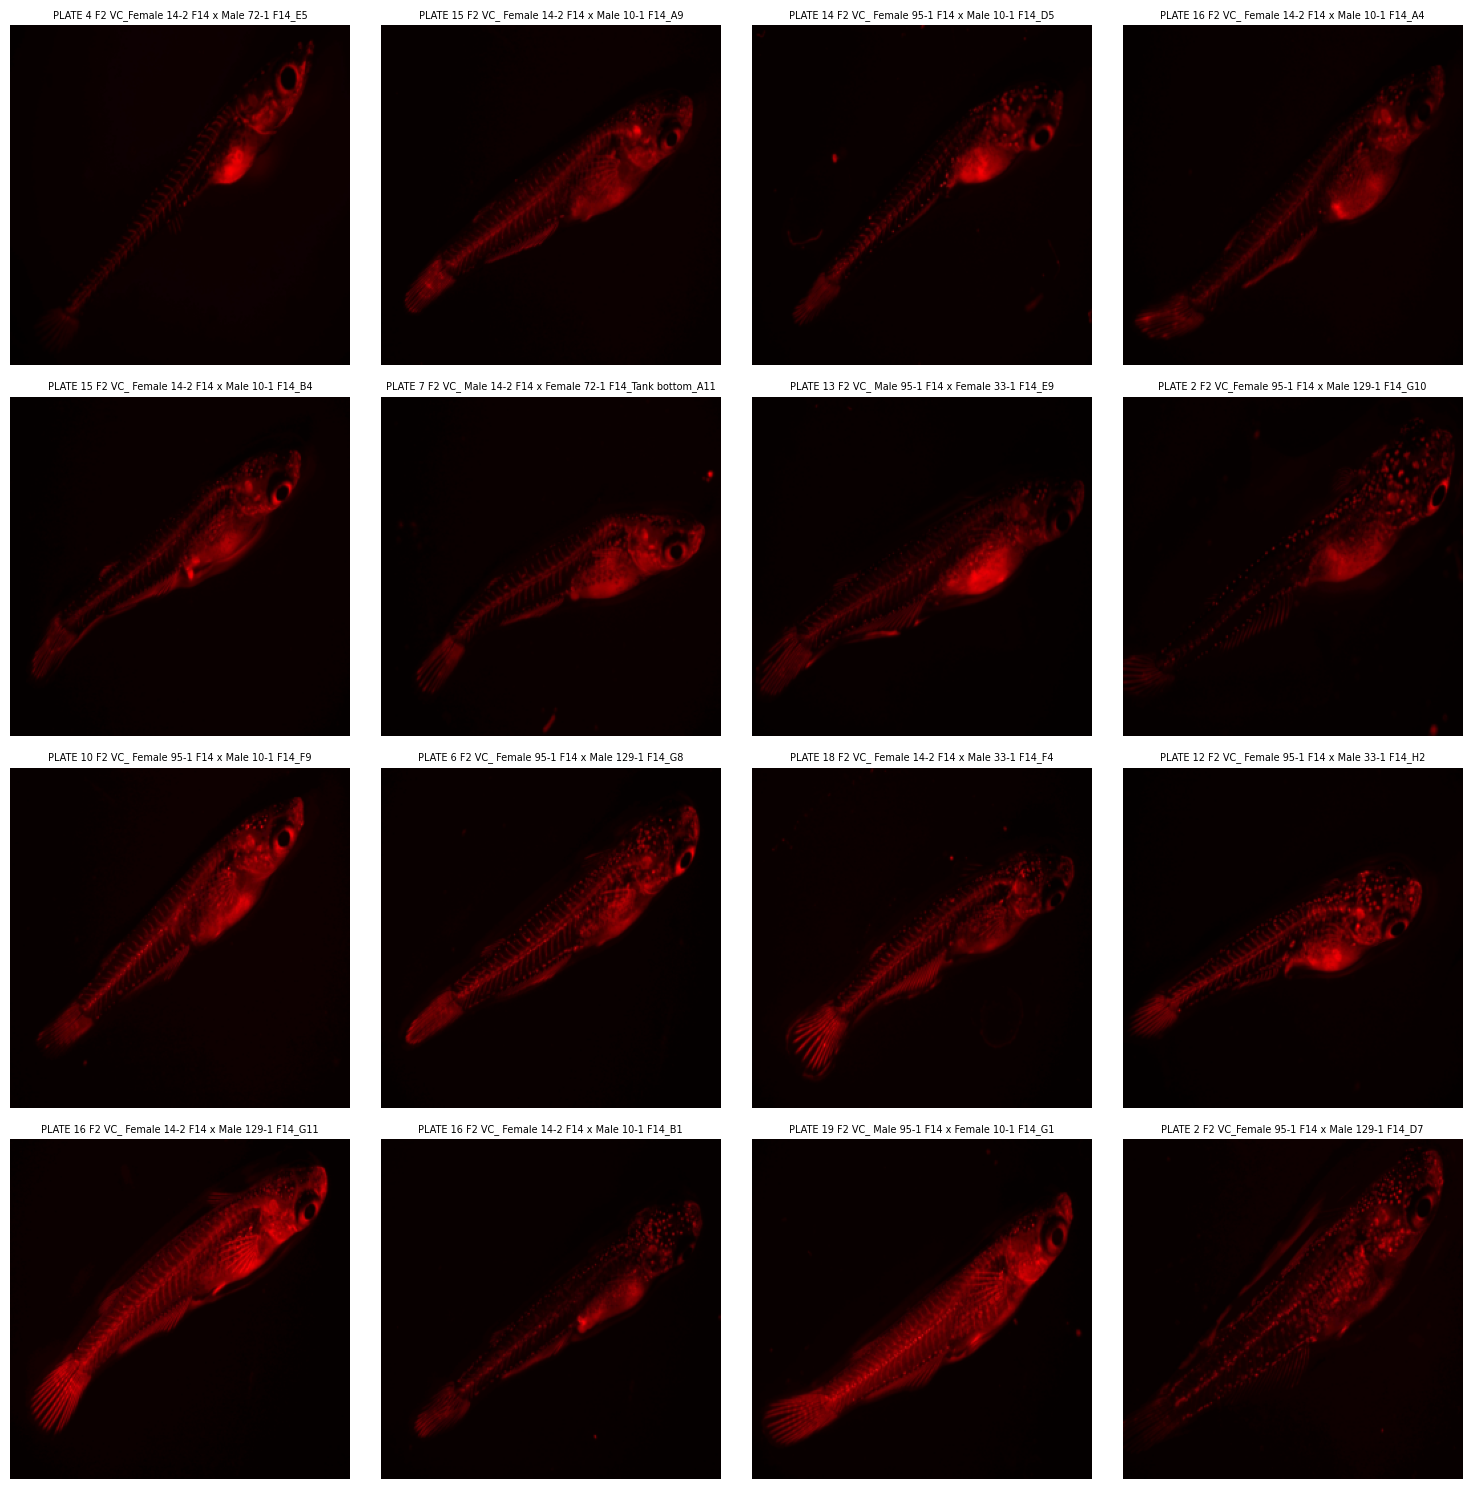

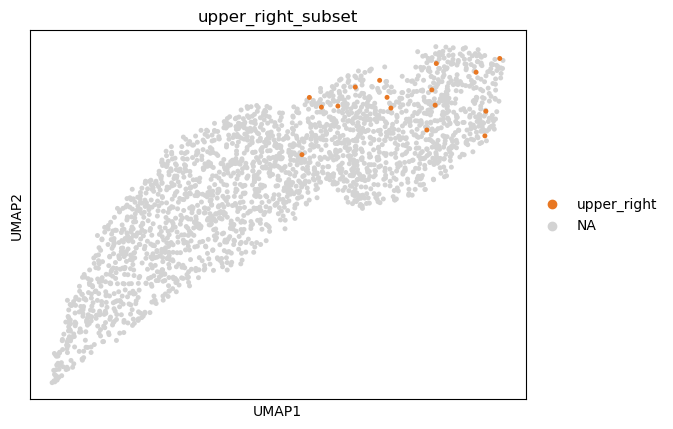

In [12]:
np.random.seed(2)

upper_right_samples, upper_right_points, upper_right_idx = get_points(x = (9, 18), 
                                                                       y = (4, 11), 
                                                                       umap_data = umap_anndata)

# Take a random subset of points in the lower left range
rand_idx = np.random.randint(low=0, high=len(upper_right_samples), size=16)

upper_right_samples_sub = [upper_right_samples[i] for i in rand_idx]
upper_right_points_sub = [upper_right_points[i] for i in rand_idx]
upper_right_idx_sub = [upper_right_idx[i] for i in rand_idx]

# Plot the UMAP
upper_right_df = pd.DataFrame({'img_name': upper_right_samples_sub, 
                              'upper_right_subset': ['upper_right']*16})

sampledata2 = sampledata.merge(upper_right_df,
                              on = 'img_name',
                              how = 'left')
# display(sampledata2[sampledata2['img_name'] == 'PLATE 9 F2 VC_ Male 14-2 F14 x Female 60-1 F14_A3'])

umap_anndata.obs['upper_right_subset'] = pd.Categorical(sampledata2['upper_right_subset'])

# Plot the fish images
fig, axs = plt.subplots(4, 4, figsize=(15, 15))
# plt.suptitle('Fish images on the bottom left cluster')
for i, ax in enumerate(axs.flatten()):
    if i < len(upper_right_points_sub):
        img = mpimg.imread('../flipped_transformed_images/image/' + upper_right_samples_sub[i] + '.tif')
        ax.imshow(img)
        ax.axis('off')
        ax.set_title(os.path.basename(upper_right_samples_sub[i]), fontsize = '7')
plt.tight_layout()
plt.savefig(workdir + 'fish_images_seed0_upper_right_subset.png')
plt.savefig(workdir + 'fish_images_seed0_upper_right_subset.svg')
plt.show()

ax = sc.pl.umap(umap_anndata, color = 'upper_right_subset',
               palette = {"upper_right": palette.core_orange},
               use_raw=False,
               show = False)
plt.savefig(workdir + 'umap_unflipped_seed0_twoclusters_upper_right_subset.png')
plt.savefig(workdir + 'umap_unflipped_seed0_twoclusters_upper_right_subset.svg')
plt.show()

### Plot UMAP with vertebrae counts

In [10]:
sampledata

,img_name
0,PLATE 1 F2 VC_Female 95-1 F14 x Male 72-1 F14_A01
1,PLATE 1 F2 VC_Female 95-1 F14 x Male 72-1 F14_A02
2,PLATE 1 F2 VC_Female 95-1 F14 x Male 72-1 F14_A03
3,PLATE 1 F2 VC_Female 95-1 F14 x Male 72-1 F14_A04
4,PLATE 1 F2 VC_Female 95-1 F14 x Male 72-1 F14_A05
...,...
2348,PLATE 25 F2 VC_ Male 11-2 F15 x Female 72-1 F1...
2349,PLATE 25 F2 VC_ Male 11-2 F15 x Female 72-1 F1...
2350,PLATE 25 F2 VC_ Male 11-2 F15 x Female 72-1 F1...
2351,PLATE 25 F2 VC_ Male 11-2 F15 x Female 72-1 F1...


In [13]:
verta_df

,name,abdominal,caudal,total
0,PLATE 1 F2 VC_Female 95-1 F14 x Male 72-1 F14_A01,12,18,30
1,PLATE 1 F2 VC_Female 95-1 F14 x Male 72-1 F14_A02,12,19,31
2,PLATE 1 F2 VC_Female 95-1 F14 x Male 72-1 F14_A03,13,18,31
3,PLATE 1 F2 VC_Female 95-1 F14 x Male 72-1 F14_A04,12,19,31
4,PLATE 1 F2 VC_Female 95-1 F14 x Male 72-1 F14_A05,12,19,31
...,...,...,...,...
2251,PLATE 25 F2 VC_ Male 11-2 F15 x Female 72-1 F1...,13,17,30
2252,PLATE 25 F2 VC_ Male 11-2 F15 x Female 72-1 F1...,13,17,30
2253,PLATE 25 F2 VC_ Male 11-2 F15 x Female 72-1 F1...,13,17,30
2254,PLATE 25 F2 VC_ Male 11-2 F15 x Female 72-1 F1...,13,17,30


{nan: '#a6cee3', 15.0: '#1f78b4', 14.0: '#b2df8a', 13.0: '#dddf8a', 12.0: '#fcb2b2', 11.0: '#e31a1c', 4.0: '#fdbf6f', 0.0: '#ff7f00'}


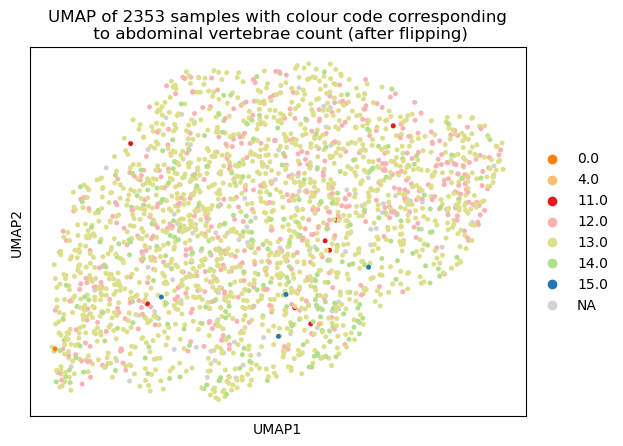

In [65]:
verta_file = '/nfs/research/birney/users/esther/medaka-img/verta_df.txt'
verta_df = pd.read_csv(verta_file, delimiter='\t')
verta_df['total'] = verta_df['abdominal'] + verta_df['caudal']
verta_df['name'] = verta_df['name'].str.replace('.tif$', '', regex=True)

sampledata3 = sampledata.merge(verta_df,
                               left_on = 'img_name',
                               right_on = 'name',
                               how = 'left')

# sampledata3['abdominal'] = sampledata3['abdominal'].astype(int)
# sampledata3['caudal'] = sampledata3['caudal'].astype(int)
# sampledata3['total'] = sampledata3['total'].astype(int)

umap_anndata.obs['abdominal'] = pd.Categorical(sampledata3['abdominal'])
umap_anndata.obs['caudal'] = pd.Categorical(sampledata3['caudal'])
umap_anndata.obs['total'] = pd.Categorical(sampledata3['total'])

# print(sorted(umap_anndata.obs['abdominal'].unique().tolist()))
colorbrewer = ['#a6cee3','#1f78b4','#b2df8a','#dddf8a','#fcb2b2','#e31a1c','#fdbf6f','#ff7f00']

abdominal_palette = dict(zip(sorted(umap_anndata.obs['abdominal'].unique().tolist(), reverse = True), 
                             colorbrewer))

print(abdominal_palette)
# palette.colors[0:len(umap_anndata.obs['abdominal'].uniquepi().tolist())])

# print(abdominal_palette)

ax = sc.pl.umap(umap_anndata, color = 'abdominal',
               palette = abdominal_palette,
               use_raw=False,
               show = False)
ax.set_title("UMAP of 2353 samples with colour code corresponding\n to abdominal vertebrae count (after flipping)")

plt.savefig(workdir + 'abdominal_vertebrae_umap.png', bbox_inches='tight')
plt.savefig(workdir + 'abdominal_vertebrae_umap.svg', bbox_inches='tight')

plt.show()

{0.0: '#a6cee3', 15.0: '#1f78b4', 16.0: '#b2df8a', 17.0: '#dddf8a', 18.0: '#fcb2b2', 19.0: '#e31a1c', nan: '#fdbf6f'}


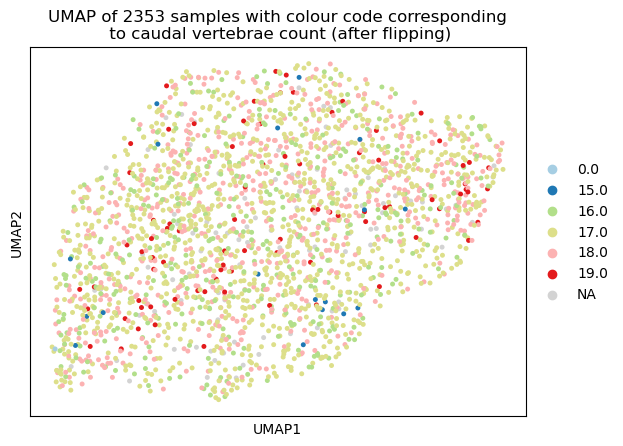

In [66]:
# colorbrewer = ['#d73027', '#f46d43', '#fdae61', '#fee090',
#               '#e0f3f8', '#abd9e9', '#74add1', '#4575b4']
colorbrewer = ['#a6cee3','#1f78b4','#b2df8a','#dddf8a','#fcb2b2','#e31a1c','#fdbf6f','#ff7f00']

abdominal_palette = dict(zip(sorted(umap_anndata.obs['caudal'].unique().tolist(), reverse = False), 
                             colorbrewer))

print(abdominal_palette)

ax = sc.pl.umap(umap_anndata, color = 'caudal',
               palette = abdominal_palette,
               use_raw=False,
               show = False)
ax.set_title("UMAP of 2353 samples with colour code corresponding\n to caudal vertebrae count (after flipping)")

plt.savefig(workdir + 'caudal_vertebrae_umap.png', bbox_inches='tight')
plt.savefig(workdir + 'caudal_vertebrae_umap.svg', bbox_inches='tight')

plt.show()

In [17]:
print(feature_matrix_anndata.var_names)
print(feature_matrix_anndata.obs_names)
print(umap_anndata.obsm['X_umap'])
print(umap_anndata.obsm['X_umap'][:,0])

Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
       ...
       '502', '503', '504', '505', '506', '507', '508', '509', '510', '511'],
      dtype='object', length=512)
Index(['PLATE 1 F2 VC_Female 95-1 F14 x Male 72-1 F14_A01',
       'PLATE 1 F2 VC_Female 95-1 F14 x Male 72-1 F14_A02',
       'PLATE 1 F2 VC_Female 95-1 F14 x Male 72-1 F14_A03',
       'PLATE 1 F2 VC_Female 95-1 F14 x Male 72-1 F14_A04',
       'PLATE 1 F2 VC_Female 95-1 F14 x Male 72-1 F14_A05',
       'PLATE 1 F2 VC_Female 95-1 F14 x Male 72-1 F14_A06',
       'PLATE 1 F2 VC_Female 95-1 F14 x Male 72-1 F14_A07',
       'PLATE 1 F2 VC_Female 95-1 F14 x Male 72-1 F14_A08',
       'PLATE 1 F2 VC_Female 95-1 F14 x Male 72-1 F14_A09',
       'PLATE 1 F2 VC_Female 95-1 F14 x Male 72-1 F14_A10',
       ...
       'PLATE 25 F2 VC_ Male 11-2 F15 x Female 72-1 F14_D3',
       'PLATE 25 F2 VC_ Male 11-2 F15 x Female 72-1 F14_D4',
       'PLATE 25 F2 VC_ Male 11-2 F15 x Female 72-1 F14_D5',
       'PLATE 25 F2 VC_ Ma